The goal of this notebook is to be able to predict fake ppg signal. 

In [1]:
# imports
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from scipy.fftpack import fft
import pywt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from scipy.signal import spectrogram

In [2]:
# load and label the data from "predictions" folder
folder_path = '/mnt/d/DeepPhys_predictions'
files = os.listdir(folder_path)
data_list = []

for file in files:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))

# load and label the data from "predictions2" folder
folder_path2 = '/mnt/d/DeepPhys_predictions2'
files2 = os.listdir(folder_path2)

for file in files2:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path2, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))

# load and label the data from "predictions3" folder
folder_path3 = '/mnt/d/DeepPhys_predictions3'
files3 = os.listdir(folder_path3)

for file in files3:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path3, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))
    
# load and label the data from "predictions4" folder
folder_path4 = '/mnt/d/DeepPhys_predictions4'
files4 = os.listdir(folder_path4)

for file in files4:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path4, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))
    
# load and label the data from "predictions5" folder
folder_path5 = '/mnt/d/PhysNet_predictions'
files5 = os.listdir(folder_path5)

for file in files5:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path5, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))

# load and label the data from "predictions6" folder
folder_path6 = '/mnt/d/PhysNet_predictions2'
files6 = os.listdir(folder_path6)

for file in files6:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path6, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))

# load and label the data from "predictions7" folder
folder_path7 = '/mnt/d/PhysNet_predictions3'
files7 = os.listdir(folder_path7)

for file in files7:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path7, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))

# load and label the data from "predictions8" folder
folder_path8 = '/mnt/d/PhysNet_predictions4'
files8 = os.listdir(folder_path8)

for file in files8:
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path8, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    data_list.append((signal, is_fake))
        
# print the number of signals and their labels
print(f'Number of signals: {len(data_list)}')
print(f'Number of fake signals: {sum([is_fake for _, is_fake in data_list])}')
print(f'Number of real signals: {len(data_list) - sum([is_fake for _, is_fake in data_list])}')


Number of signals: 1528
Number of fake signals: 1005
Number of real signals: 523


# Spectogram Analysis

In [3]:
# Load and label the data from a single file in each folder
def load_single_data_from_folder(folder_path):
    files = os.listdir(folder_path)
    if not files:
        return None
    file = files[0]
    is_fake = 'fake' in file
    file_path = os.path.join(folder_path, file)
    signal = pd.read_csv(file_path)  # Modify this line if format is different
    dataset_name = os.path.basename(folder_path)
    return (signal, is_fake, dataset_name)

folder_paths = [
    '/mnt/d/DeepPhys_predictions',
    '/mnt/d/DeepPhys_predictions2',
    '/mnt/d/DeepPhys_predictions3',
    '/mnt/d/DeepPhys_predictions4',
    '/mnt/d/PhysNet_predictions',
    '/mnt/d/PhysNet_predictions2',
    '/mnt/d/PhysNet_predictions3',
    '/mnt/d/PhysNet_predictions4'
]

data_list_specto_analysis = []
for folder_path in folder_paths:
    data = load_single_data_from_folder(folder_path)
    if data is not None:
        data_list_specto_analysis.append(data)

# Print the number of signals and their labels
print(f'Number of signals: {len(data_list_specto_analysis)}')
print(f'Number of fake signals: {sum([is_fake for _, is_fake, __ in data_list_specto_analysis])}')
print(f'Number of real signals: {len(data_list_specto_analysis) - sum([is_fake for _, is_fake, __ in data_list_specto_analysis])}')

# Define a function to plot spectrogram
def plot_spectrogram(signal, fs=100, title="Spectrogram"):
    f, t, Sxx = spectrogram(signal, fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Generate spectrograms for one fake and one real signal from each folder
for signal_df, is_fake, dataset_name in data_list_specto_analysis:
    signal_values = signal_df.iloc[:, 0].values
    label = 'Fake' if is_fake else 'Real'
    print(f"{dataset_name} {label} Signal Spectrogram")
    # plot_spectrogram(signal_values, title=f"{label} Signal Spectrogram")

Number of signals: 8
Number of fake signals: 4
Number of real signals: 4
DeepPhys_predictions Real Signal Spectrogram
DeepPhys_predictions2 Fake Signal Spectrogram
DeepPhys_predictions3 Real Signal Spectrogram
DeepPhys_predictions4 Fake Signal Spectrogram
PhysNet_predictions Real Signal Spectrogram
PhysNet_predictions2 Fake Signal Spectrogram
PhysNet_predictions3 Real Signal Spectrogram
PhysNet_predictions4 Fake Signal Spectrogram


In [4]:
import numpy as np
from scipy.signal import spectrogram, welch
import pandas as pd

# Function to compute Power Spectral Density (PSD)
def compute_psd(signal, fs=100):
    f, Pxx = welch(signal, fs, nperseg=1024)
    return f, Pxx

# Function to compute Spectral Entropy
def spectral_entropy(Pxx):
    Pxx_norm = Pxx / np.sum(Pxx)  # Normalize the power spectrum
    entropy = -np.sum(Pxx_norm * np.log2(Pxx_norm + np.finfo(float).eps))  # Avoid log(0) with eps
    return entropy

# Function to compute Spectral Flatness
def spectral_flatness(Pxx):
    geometric_mean = np.exp(np.mean(np.log(Pxx + np.finfo(float).eps)))
    arithmetic_mean = np.mean(Pxx)
    flatness = geometric_mean / arithmetic_mean
    return flatness

# Function to compute metrics for a signal
def compute_metrics(signal, fs=100):
    f, Pxx = compute_psd(signal, fs)
    entropy = spectral_entropy(Pxx)
    flatness = spectral_flatness(Pxx)
    mean_psd = np.mean(Pxx)
    var_psd = np.var(Pxx)
    return {
        'Entropy': entropy,
        'Flatness': flatness,
        'Mean_PSD': mean_psd,
        'Variance_PSD': var_psd
    }

# Analyze a sample of signals from each folder
metrics_list = []

for signal_df, is_fake,dataset_name in data_list_specto_analysis:
    signal_values = signal_df.iloc[:, 0].values
    metrics = compute_metrics(signal_values)
    metrics['Label'] = 'Fake' if is_fake else 'Real'
    metrics_list.append(metrics)

# Convert metrics to DataFrame for analysis
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# Summary statistics for each metric
summary_stats = metrics_df.groupby('Label').agg(['mean', 'std'])
print(summary_stats)



    Entropy    Flatness      Mean_PSD  Variance_PSD Label
0  5.625269    0.000419  9.228765e-05  1.234484e-07  Real
1  3.434118    0.000006  1.957898e-05  2.359513e-08  Fake
2  6.002849  143.976881  1.552690e-18  2.141773e-35  Real
3  5.859867  579.560538  3.837820e-19  1.586589e-36  Fake
4  5.932061    0.000047  9.821274e-02  1.137279e-01  Real
5  4.025590    0.042122  1.226845e-01  1.260848e+00  Fake
6  4.020150    0.000092  1.217183e-01  8.335217e-01  Real
7  4.370728    0.000040  5.243469e-01  1.238032e+01  Fake
        Entropy              Flatness              Mean_PSD            \
           mean       std        mean         std      mean       std   
Label                                                                   
Fake   4.422576  1.033302  144.900676  289.773242  0.161763  0.248544   
Real   5.395082  0.931155   35.994360   71.988348  0.055006  0.064183   

      Variance_PSD            
              mean       std  
Label                         
Fake      3.410292 

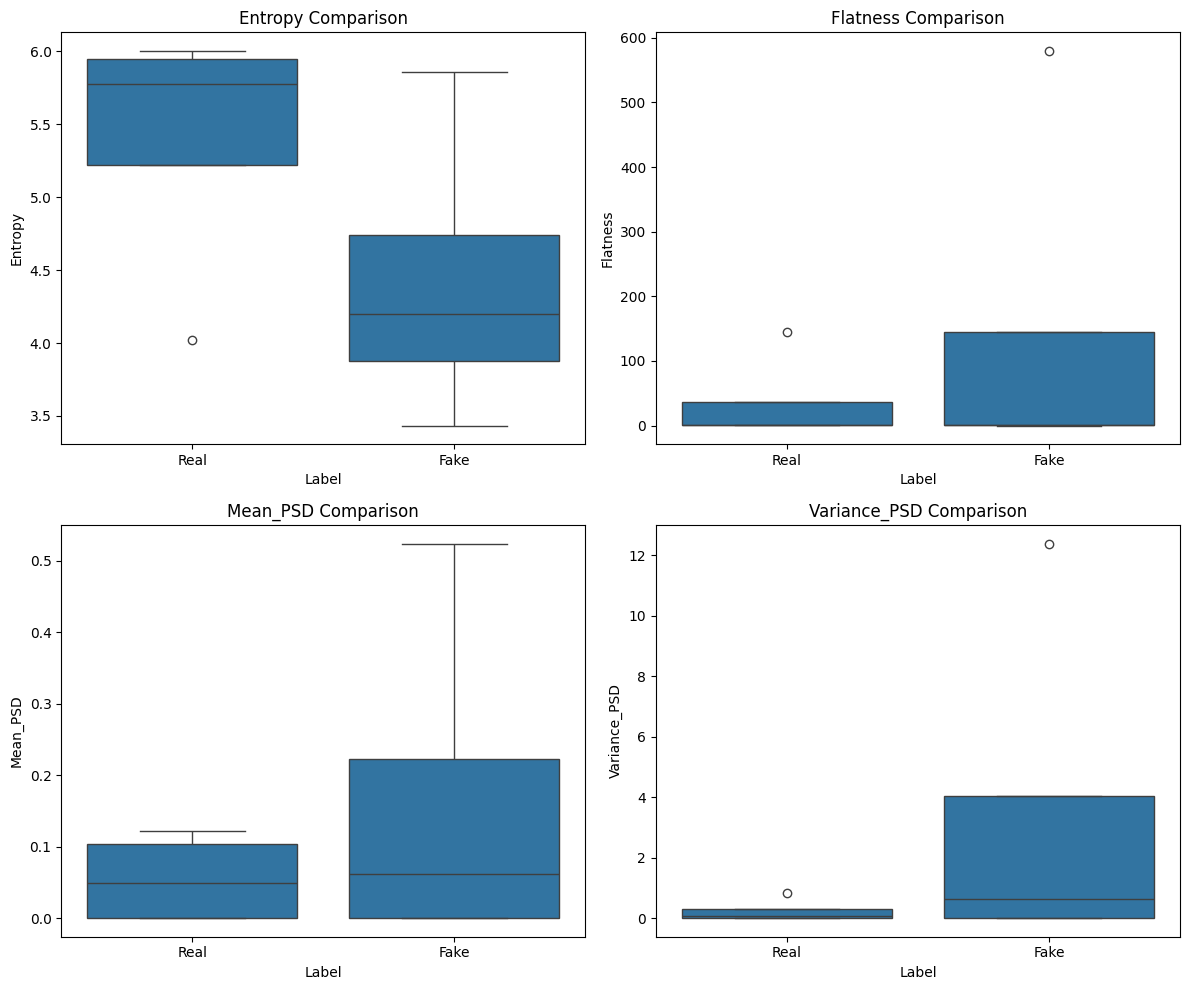

In [5]:

# Plot the metrics for comparison
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x='Label', y='Entropy', data=metrics_df, ax=axs[0, 0])
axs[0, 0].set_title('Entropy Comparison')

sns.boxplot(x='Label', y='Flatness', data=metrics_df, ax=axs[0, 1])
axs[0, 1].set_title('Flatness Comparison')

sns.boxplot(x='Label', y='Mean_PSD', data=metrics_df, ax=axs[1, 0])
axs[1, 0].set_title('Mean_PSD Comparison')

sns.boxplot(x='Label', y='Variance_PSD', data=metrics_df, ax=axs[1, 1])
axs[1, 1].set_title('Variance_PSD Comparison')

plt.tight_layout()
plt.show()


The metrics and their visual representations clearly distinguish between real and fake PPG signals:

1. **Entropy**: Real signals are more complex and consistent, whereas fake signals are less complex and more variable.
2. **Flatness**: Real signals have a peaky power spectrum, while fake signals have a flatter and more variable power spectrum.
3. **Mean_PSD**: Real signals show lower and more consistent power, while fake signals have higher and more variable power.
4. **Variance_PSD**: Real signals have a consistent power distribution, while fake signals show irregular and variable power distribution.


# Features 

**Sampling Rate:** I assumed the sampling rate is equal to the length of the signal for rfftfreq. You should adjust d=1/sampling_rate where sampling_rate is the actual rate at which your data was sampled.

**Zero Crossing Rate (ZCR):** This feature counts how often the signal crosses zero, which can indicate the frequency content of the noise.

**Spectral Centroid and Rolloff:** These features give a sense of where the "center of mass" for the sound spectrum is located and where the bulk of the energy lies in the frequency spectrum.

**Wavelet Transform Features:** Provide a measure of the distribution of energy across different frequency bands and the entropy of the signal representation in the wavelet domain.

In [6]:
def zero_crossings(signal):
    # Calculate zero crossings
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    return len(zero_crossings)

def perfusion_index(signal):
    # Calculate perfusion index
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return std_signal / mean_signal if mean_signal != 0 else 0

# Step 2: Feature Extraction
def extract_advanced_features(signal):
    features = {}
    
    # Statistical Features
    features['entropy'] = -np.sum(np.log2(signal**2)) if np.all(signal != 0) else 0
    features['rms'] = np.sqrt(np.mean(signal**2))
    
    # Morphological Features
    features['kurtosis'] = kurtosis(signal)
    features['skewness'] = skew(signal)
    derivative = np.diff(signal, n=1)
    features['mean_derivative'] = np.mean(np.abs(derivative))
    
    # Spectral Features
    freqs, power = welch(signal, fs=len(signal))
    low_freq_power = np.sum(power[freqs < 0.1])  # Customize frequency bands based on your sampling rate
    high_freq_power = np.sum(power[freqs >= 0.1])
    features['lf_hf_ratio'] = low_freq_power / high_freq_power if high_freq_power != 0 else 0
    features['spectral_entropy'] = -np.sum((power / np.sum(power)) * np.log2(power / np.sum(power)))
    
    # Autocorrelation
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr /= autocorr.max()  # Normalize
    features['autocorr_decay'] = autocorr[len(signal)//2 + 10]  # offset to avoid the central peak
    
    # Zero Crossing
    features['zero_crossings'] = zero_crossings(signal)
    
    # Perfusion Index
    features['perfusion_index'] = perfusion_index(signal)
    
    return features

# Assemble data
features_list = []
labels = []

for signal, is_fake in data_list:
    features = extract_advanced_features(signal.squeeze())  # Ensure signal is a 1D array
    features_list.append(features)
    labels.append(is_fake)

In [7]:
# Step 3: Data Preparation
features_df = pd.DataFrame(features_list)
labels = np.array(labels)

In [8]:
# def add_noise(signal, noise_level=0.01):
#     noise = np.random.normal(0, noise_level, signal.shape)
#     return signal + noise

# # Applying noise addition to each signal
# for i in range(len(data_list)):
#     signal, is_fake = data_list[i]
#     noisy_signal = add_noise(signal.squeeze())
#     data_list[i] = (noisy_signal, is_fake)
    

# Assuming features and labels are extracted
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features_df, labels)

# Check the balance of the new dataset
print(np.sum(labels_resampled == 1), np.sum(labels_resampled == 0))

1005 1005


In [9]:
# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_resampled)
# At this point, 'scaled_features' and 'labels' are ready for training a model
# show the first 5 rows of the features dataframe
print(features_resampled.head())

        entropy       rms   kurtosis  skewness  mean_derivative  lf_hf_ratio  \
0  18511.953550  0.094230  14.321014  0.015749         0.015242     0.000208   
1   6514.931797  0.286813   1.231798  0.378779         0.024337     0.002493   
2   7159.909838  0.272785  40.079700  5.575679         0.078283     0.000991   
3   6452.678450  0.392782  13.539494  3.718027         0.229007     0.000560   
4  12092.876935  0.263328   5.346633 -0.238663         0.051312     0.000255   

   spectral_entropy  autocorr_decay  zero_crossings  perfusion_index  
0          4.000289        0.024558             160       188.988879  
1          6.800119        0.502695               0        -0.077901  
2          5.884484        0.401178             116        -0.491703  
3          4.606325        0.066724             276        -1.878138  
4          3.994217        0.009478             156     -2976.935563  


In [10]:
# Define classifiers and their hyperparameters
classifiers = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'SVM': (SVC(random_state=42), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'DecisionTree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [2, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [2, 5, 10]
    }),
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=10000), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }),
    'NaiveBayes': (GaussianNB(), {})
}

best_score = 0
best_clf = None
best_params = None
best_name = ""

In [11]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels_resampled, test_size=0.2, random_state=42)


In [12]:
# Loop through classifiers and perform Grid Search
for name, (clf, param_grid) in classifiers.items():
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Classifier: {name}")
    print("Best Params:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_clf = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_name = name

Classifier: RandomForest
Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.9533582089552238
Classifier: SVM
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9409203980099502
Classifier: KNN
Best Params: {'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.9452736318407959
Classifier: DecisionTree
Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 0.9396766169154228
Classifier: GradientBoosting
Best Params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
Best Score: 0.9533582089552238
Classifier: LogisticRegression
Best Params: {'C': 10, 'solver': 'liblinear'}
Best Score: 0.9060945273631841
Classifier: NaiveBayes
Best Params: {}
Best Score: 0.759950248756219



Best Classifier: RandomForest
Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.9533582089552238
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.93      0.96       204
        True       0.93      0.98      0.96       198

    accuracy                           0.96       402
   macro avg       0.96      0.96      0.96       402
weighted avg       0.96      0.96      0.96       402

Confusion Matrix:
[[190  14]
 [  3 195]]
Training Accuracy:  0.9720149253731343
Test Accuracy:  0.9577114427860697


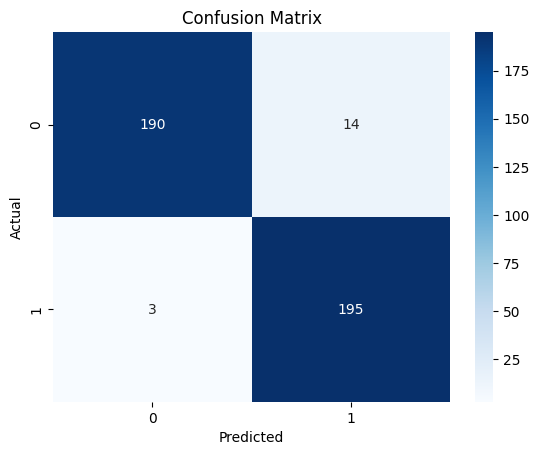

In [16]:
# Step 6: Evaluate the Best Model
print(f"\nBest Classifier: {best_name}")
print("Best Params:", best_params)
print("Best CV Score:", best_score)

y_pred = best_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

train_preds = best_clf.predict(X_train)
test_preds = best_clf.predict(X_test)

print("Training Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))

# plot the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


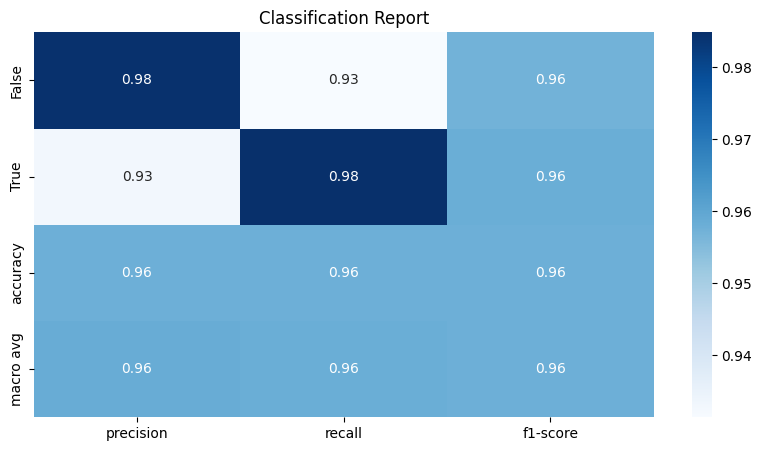

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot the classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report')
plt.show()
# save png file
plt.savefig('classification_report.png')


In [ ]:
# Cross-validation with 5 folds
cv_scores = cross_val_score(best_clf, scaled_features, labels_resampled, cv=5)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation in CV:", np.std(cv_scores))

Cross-Validation Accuracy Scores: [0.96766169 0.94527363 0.9278607  0.97263682 0.87064677]
Mean CV Accuracy: 0.9368159203980099
Standard Deviation in CV: 0.036782289331889574


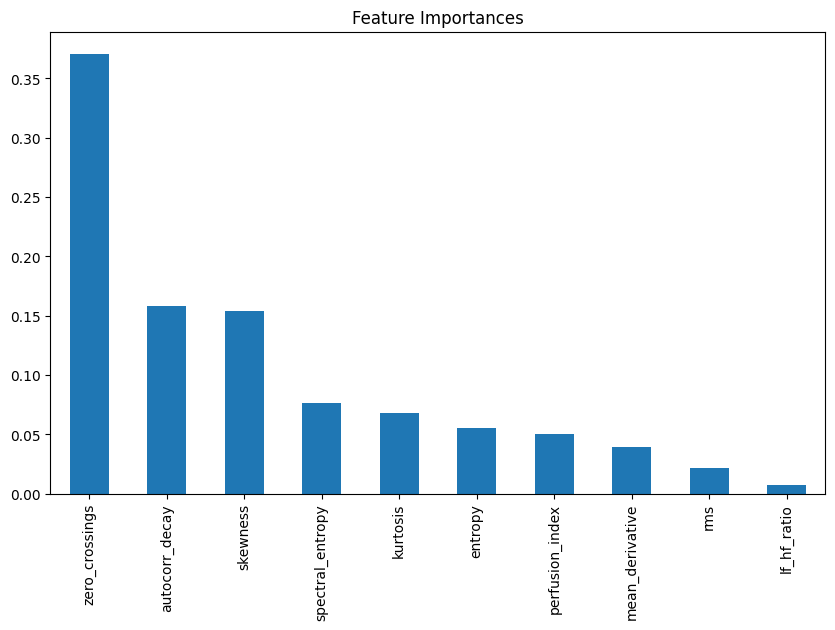

                  importance
zero_crossings      0.370804
autocorr_decay      0.157738
skewness            0.154093
spectral_entropy    0.076424
kurtosis            0.067675
entropy             0.055323
perfusion_index     0.050114
mean_derivative     0.039360
rms                 0.021279
lf_hf_ratio         0.007191


In [ ]:
feature_importances = pd.DataFrame(best_clf.feature_importances_, 
                                   index=features_resampled.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances['importance'].plot(kind='bar')
plt.title('Feature Importances')
plt.show()
#print also the feature importances
print(feature_importances)

1. **Autocorr_decay**: This measures how quickly the autocorrelation of a signal decreases over time. A higher value indicates that the signal is more self-similar over time.

2. **Zero_crossings**: This counts the number of times the signal crosses the zero axis. It's a measure of the signal's frequency content and variability.

3. **Skewness**: This quantifies the asymmetry of the probability distribution of the signal. Positive skew indicates a distribution with a longer right tail, and negative skew indicates a longer left tail.

4. **Kurtosis**: This measures the "tailedness" of the probability distribution. Higher kurtosis indicates more outliers and sharper peaks, while lower kurtosis indicates a more uniform distribution.

5. **Spectral_entropy**: This represents the entropy (or randomness) of the power spectrum of the signal. It provides an indication of the signal's complexity in the frequency domain.

6. **Perfusion_index**: This is a measure often used in medical applications to represent the strength of blood flow in the extremities. It indicates the pulse strength.

7. **Entropy**: This quantifies the randomness or disorder of the signal. Higher entropy means the signal is more complex and less predictable.

8. **Lf_hf_ratio**: This is the ratio of low-frequency to high-frequency components of the signal, often used in heart rate variability analysis to assess autonomic nervous system balance.

9. **Mean_derivative**: This measures the average rate of change of the signal. It indicates the overall trend and volatility of the signal.

10. **Rms (Root Mean Square)**: This calculates the square root of the average of the squares of the signal values. It's a measure of the signal's magnitude and provides a sense of its power.

In [ ]:
# Step 6: Evaluate the Model
y_pred = best_clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.93      0.96       204
        True       0.93      0.98      0.96       198

    accuracy                           0.96       402
   macro avg       0.96      0.96      0.96       402
weighted avg       0.96      0.96      0.96       402

Confusion Matrix:
[[190  14]
 [  3 195]]


/home/guourg5/miniconda3/envs/rppg-toolbox/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


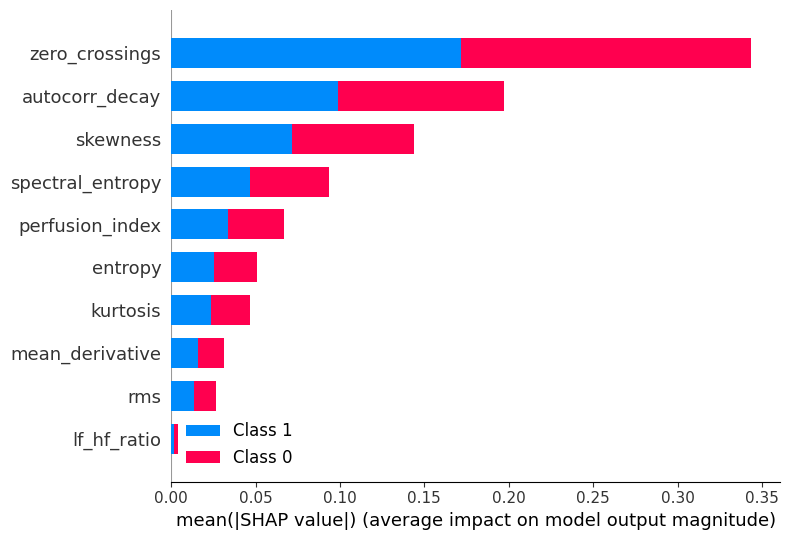

In [ ]:
import shap

# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_train)

# Plot summary plot for SHAP values
shap.summary_plot(shap_values, X_train, feature_names=features_resampled.columns)


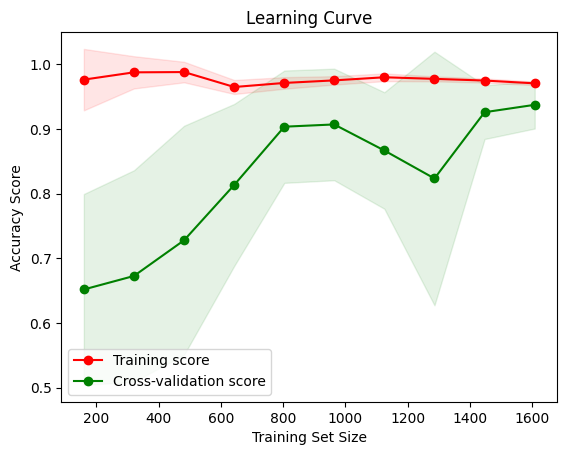

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    best_clf, features_resampled, labels_resampled, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std,
                 validation_mean + validation_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()


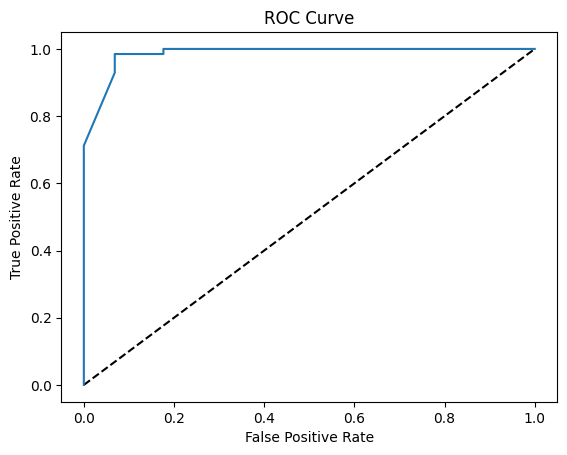

In [ ]:
# show the AUC-ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


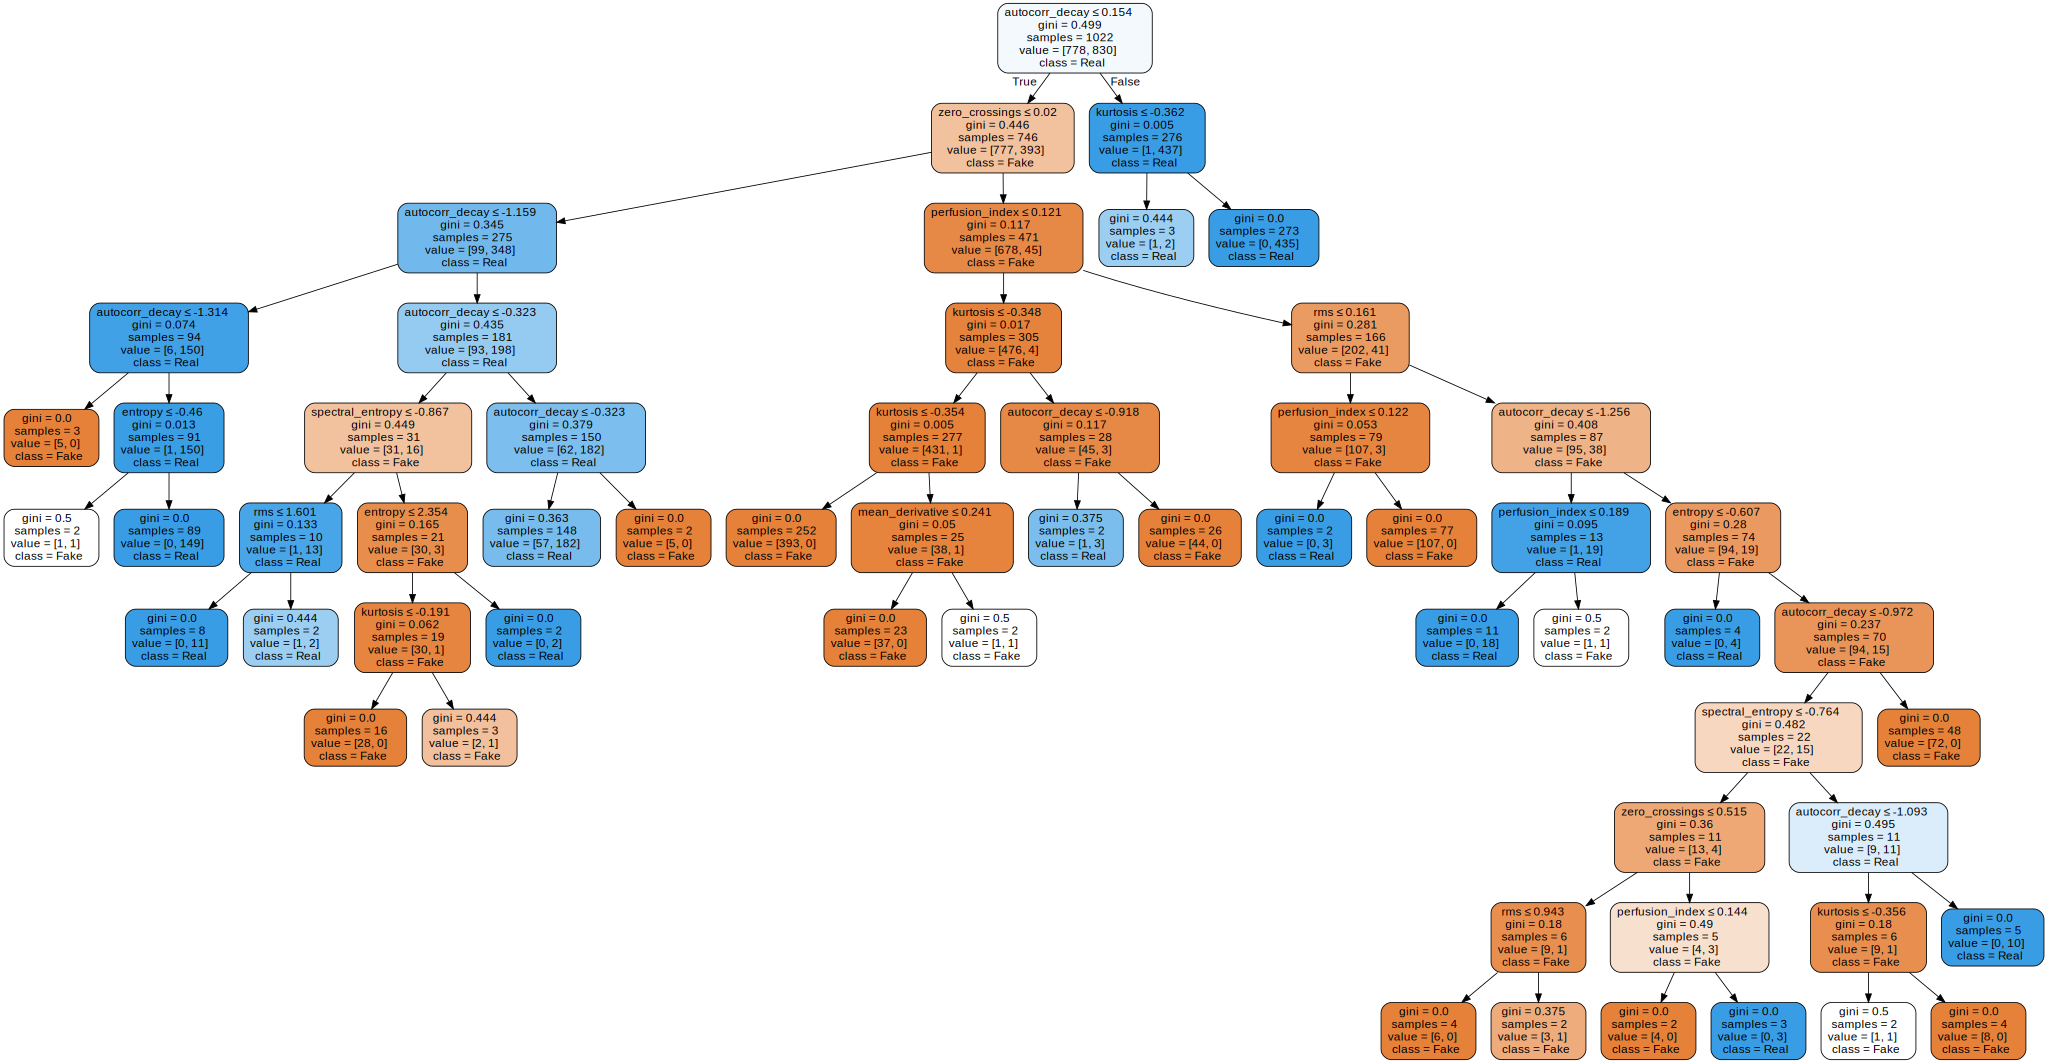

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Visualize one of the trees in the forest
tree = best_clf.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=features_resampled.columns,  
                           class_names=['Fake', 'Real'], 
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("random_forest_tree")

# Display the tree
graph
